# TP2 Prévision de consommation avec réseau de neurones


<img src="pictures/Présentation_FormationIA_TPDeepLearning.png" width=1000 height=60>

**Dans l'épisode précédent**  

Nos modèles de régression par décomposition saisonnière du TP1 avec la librairie Prophet nous ont donné des premiers résultats et des premières intuitions sur notre problème de prévision de consommation pour le lendemain. 

Nous avons pu analyser des profils de courbe de consommation au jour, à la semaine, au mois. Nous avons également observé la dépendance entre la consommation et la consommation retardée. Nous avons aussi vu l'impact des jours fériés. En intégrant ces différents facteurs nous sommes arrivés à une erreur moyenne de test de 4,1%.

Nous avons ensuite utilisé de premiers modèles en machine learning pour apprendre par observations l'influence de différents contextes sur la consommation sans les décrires explicitement selon des lois. 
Des difficultés se sont posées pour intégrer les variables météorologiques très dépendantes entre elles et pour intégrer un vecteur de consommation retardée.

Avec l'approche classique exposée dans ce TP1, nous avons en particulier constaté le besoin d'une expertise et d'un travail autour des variables explicatives pour obtenir un modèle performant.



**Aujourd'hui** 

Nous allons de nouveau nous attaquer à ce sujet de la prévision de consommation nationale pour le lendemain, mais cette fois en utilisant un modèle de prévision par réseau de neurones. Nous allons exploiter leur capacité à capter ces phénomènes non-linéaires et interdépendants. Nous allons mettre en évidence le moindre besoin en feature engineering en travaillant directement à la granularité de la donnée,sans créer de variables agrégées ou transformées par de l'expertise.

**Ce que vous allez voir dans ce second TP**

- Un rappel de notre problème et récapitulatif des performances de nos modèles précédents
- Une nouvelle méthode numérique pour préparer ses données et faciliter l'apprentissage: la normalisation
- La création d'un premier réseau de neurones pour prédire la consommation dans 24h
- L'utilisation de tensorboard pour observer en temps réel la courbe d'apprentissage du réseau de neurones
- La création de modèles de plus en plus performants en intégrant davantage d'informations dans notre modélisation
- L'évaluation des modèles sur 2 types de jeux de test

**Ce que vous allez devoir faire**

- Compléter les quelques trous de codes que nous vous avons laissé si vous le souhaitez. La solution est disponible dans le TP complété.
- Répondre aux quelques questions disséminées dans ce TP
- Entrainer votre propre modèle pour améliorer les performances d'un modèle existant et essayer de remporter notre mini-challenge !

__NB__ : Pour ce TP nous utiliserons Keras, une bibliothèque python de haut niveau qui appelle des fonctions de la librairie TensorFlow. D'autres librairies existent, Keras a été retenue en raison de sa facilité d'utilisation.

# Dimensionnement en temps
La durée estimée de ce TP est d'environ 1h30 :
- 10-20 minutes pour charger et préparer les données pour les réseaux de neurones 
- 10-20 minutes pour entrainer un premier modèle de réseau de neurones, en examiner le code implémentant ce réseau de neurones
- Le reste pour jouer et tenter d'améliorer la qualité de la prédiction avec de nouvelles variables explicatives, ou en choisissant d'autres hyper-paramètres. 

# I) Préparation des données

## Chargement des librairies nécessaires

In [2]:
import os
import numpy as np
import pandas as pd
import random
import datetime
from IPython.display import SVG

import plotly
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# sklearn est la librairie de machine learning en python et scipy une librairie statistiques
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy import stats

#######
# Keras est la librairie que nous utilisons pour se créer des modèles de réseau de neurones
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils import plot_model
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.callbacks import TensorBoard
from time import time

import zipfile


K.set_image_data_format('channels_last')

%matplotlib inline

Using TensorFlow backend.


## Localisation des données

In [3]:
## Choix du répertoire de travail "data_folder" dans lequel toutes les fichiers csv seront entreposés

# a actualiser avec le repertoire par defaut sur le serveur
data_folder = os.path.join(os.getcwd(),"data")

### Petite vérification
print("Mon repertoire est : {}".format(data_folder))
print("Fichiers contenus dans ce répertoire :")
for file in os.listdir(data_folder):
    print(" - " + file)

Mon repertoire est : /home/marotant/dev/TP_Formation_Conso_DeepLearning/data
Fichiers contenus dans ce répertoire :
 - Xinput.zip
 - Xinput_old.zip
 - Yconso.csv
 - Xinput_scaled.zip
 - Xinput_avant.zip


## I) Récupération et préparation des données

Dans cette partie nous allons charger les fichiers csv nécessaires pour l'analyse, puis les convertir en data-frame python. Les données de base à récupérer sont :
- la base de données issues du TP1 (Les historiques de consommation, leur lag, les données météo en température, leur lag, les jours feriés) 

En terme de transformation des données pour mieux les préparer:

- nous allons aussi voir comment normaliser les données, une transformation souvent bien utile en pratique pour une meilleure convergence numérique. 

Cela vient compléter les transformations vu précédemment pour les données calendaires, et aussi la transformation "one-hot" pour les données catégorielles

### Récupération de nos variables explicatives XInput

#### Les données d'entrée sont encryptées.

En effet les données météo sont confidentielles. Pour les lire vous avez besoin d'un mot de passe qui ne peut vous être donné que dans le cadre d'un travail au sein de RTE


In [4]:
password=None#

In [5]:
Xinput_zip = os.path.join(data_folder, "Xinput_scaled.zip")
zfXinput = zipfile.ZipFile(Xinput_zip)#.extractall(pwd=bytes(password,'utf-8'))
zfXinput.setpassword(bytes(password,'utf-8'))
Xinput_scaled = pd.read_csv(zfXinput.open('Xinput_scaled.csv'),sep=",",engine='c',header=0)

Xinput_scaled['ds']=pd.to_datetime(Xinput_scaled['ds'])


In [6]:
print("voici la taille de votre jeu de données")
print(Xinput_scaled.shape)

voici la taille de votre jeu de données
(38875, 205)


## **Question**
Que représentent ici ces dimensions ?

In [7]:
# Votre reponse ici


In [8]:
print("voici toutes les variables explicatives que l'on peut utiliser")
Xinput_scaled.columns.get_values()

voici toutes les variables explicatives que l'on peut utiliser


array(['ds', 'weekday', 'lag1D', 'lag1W', '002Th_real', '005Th_real',
       '015Th_real', '027Th_real', '070Th_real', '110Th_real',
       '120Th_real', '130Th_real', '145Th_real', '149Th_real',
       '156Th_real', '168Th_real', '180Th_real', '190Th_real',
       '222Th_real', '240Th_real', '255Th_real', '260Th_real',
       '280Th_real', '299Th_real', '434Th_real', '460Th_real',
       '481Th_real', '497Th_real', '510Th_real', '579Th_real',
       '588Th_real', '621Th_real', '630Th_real', '643Th_real',
       '645Th_real', '650Th_real', '675Th_real', '690Th_real',
       '747Th_real', 'FranceTh_real', '002Th_prev', '005Th_prev',
       '015Th_prev', '027Th_prev', '070Th_prev', '110Th_prev',
       '120Th_prev', '130Th_prev', '145Th_prev', '149Th_prev',
       '156Th_prev', '168Th_prev', '180Th_prev', '190Th_prev',
       '222Th_prev', '240Th_prev', '255Th_prev', '260Th_prev',
       '280Th_prev', '299Th_prev', '434Th_prev', '460Th_prev',
       '481Th_prev', '497Th_prev', '510Th_pre

**Pour Rappel**

Les transformations calendaires avaient été appliquées sur la variable de date 'ds' pour extraire les mois et les jours.

Les transformations "one hot" avaient été utilisées pour transformer les variables catégorielles 'month'(1 à 12) et 'hour' (1 à 24) en 'month_1...month_12' et 'hour_0...hour_23'

Les variables retardées d'une journée ont été intégrées



#### Normalisation des données
Enfin nos variables Xinput ont été normalisées.  

En théorie, la normalisation des données d'entrée n'est pas indispensable pour entrainer un réseau de neurones. En effet, on devrait apprendre des poids et biais plus ou moins importants pour équilibrer les contributions des différentes variables explicatives en entrée. 

Cependant en pratique, normaliser les données d'entrée permet généralement d'obtenir un apprentissage plus rapide du réseau de neurones.

**Question**: comment l'expliquez-vous ?

In [9]:
#####
#suppression de lignes en doublons si besoin
u, indices = np.unique(Xinput_scaled['ds'].get_values(),return_index=True) #on recupere des timeStamps en double ce qui peut arriver après jointure des données
Xinput_scaled=Xinput_scaled.iloc[indices]
Xinput_scaled.reset_index(drop=True)
Xinput_scaled.head(5)

,ds,weekday,lag1D,lag1W,002Th_real,005Th_real,015Th_real,027Th_real,070Th_real,110Th_real,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,JoursFeries_24h_avant
0,2013-01-04 00:00:00,1,0.947,59679.0,-0.230,-0.178,-0.155,-0.263,-0.130,-0.409,...,0,0,0,0,0,0,0,0,0,0.0
1,2013-01-04 01:00:00,1,0.546,55354.0,-0.230,-0.211,-0.155,-0.263,-0.142,-0.491,...,0,0,0,0,0,0,0,0,0,0.0
2,2013-01-04 02:00:00,1,0.476,54324.0,-0.213,-0.211,-0.170,-0.280,-0.181,-0.491,...,0,0,0,0,0,0,0,0,0,0.0
3,2013-01-04 03:00:00,1,0.284,52066.0,-0.195,-0.227,-0.184,-0.314,-0.219,-0.532,...,0,0,0,0,0,0,0,0,0,0.0
4,2013-01-04 04:00:00,1,0.085,49684.0,-0.230,-0.211,-0.170,-0.331,-0.219,-0.470,...,0,0,0,0,0,0,0,0,0,0.0


### Récupération de nos variables à prédire: la consommation française

In [10]:
Yconso_csv = os.path.join(data_folder, "Yconso.csv")
Y = pd.read_csv(Yconso_csv, sep=",", engine='c', header=0) 
Y['ds']=pd.to_datetime(Y['ds'])

#####
#suppression de lignes en doublons si besoin
u, indices = np.unique(Y['ds'].get_values(),return_index=True)
Y=Y.iloc[indices]
Y.reset_index(drop=True)

Y = Y.drop(['Unnamed: 0'], axis=1)
Y.head(10)

,ds,y
0,2012-12-28 00:00:00,59679.0
1,2012-12-28 01:00:00,55354.0
2,2012-12-28 02:00:00,54324.0
3,2012-12-28 03:00:00,52066.0
4,2012-12-28 04:00:00,49684.0
5,2012-12-28 05:00:00,49511.0
6,2012-12-28 06:00:00,51782.0
7,2012-12-28 07:00:00,55374.0
8,2012-12-28 08:00:00,59087.0
9,2012-12-28 09:00:00,60751.0


### Tronquer les données

Il faut tronquer les données car nous avons rajouté comme variables explicatives des lags sur la consommation et la météo qui n'ont pas de valeurs(NAN) au début de l'historique


In [11]:
nbJourlagRegresseur=7 #du fait du lag de 1 semaine pour la consommation que nous utilisons
dateStart = Xinput_scaled.iloc[0]['ds']
DateStartWithLag = dateStart + pd.Timedelta(str(nbJourlagRegresseur) + ' days')

Xinput_scaled = Xinput_scaled[(Xinput_scaled.ds >= DateStartWithLag)]
Xinput_scaled=Xinput_scaled.reset_index(drop=True)

Y = Y [(Y.ds >= DateStartWithLag)]
Y=Y.reset_index(drop=True)
Y.head(10)

,ds,y
0,2013-01-11 00:00:00,68515.0
1,2013-01-11 01:00:00,63936.0
2,2013-01-11 02:00:00,63251.0
3,2013-01-11 03:00:00,60932.0
4,2013-01-11 04:00:00,58991.0
5,2013-01-11 05:00:00,59259.0
6,2013-01-11 06:00:00,63329.0
7,2013-01-11 07:00:00,70956.0
8,2013-01-11 08:00:00,76985.0
9,2013-01-11 09:00:00,76771.0


## II) Création de jeux d'apprentissage et de test

**Question** : A quoi servent les jeux d'entrainement, de validation, et de test ?

On se crée et on extrait 2 jeux de test de type différent, les données restantes constituant notre jeu d'entrainement-validation.
Ces 2 jeux de tests sont établis ainsi:
 - sélectionner une date de coupure (mai 2017) pour évaluer notre modèle, appris sur un historique, sur une période future.
 - sélection de quelques dates au hasard en été et en hiver avec la fonction _selectDatesRandomly_ pour établir la performance de notre modèle sur des journées thermosensibles.


In [12]:
def selectDatesRandomly(XwithDs, quarter, nDays, seed=10):
    joursQuarter = np.unique(XwithDs.loc[np.where(XwithDs.ds.dt.quarter == quarter)].ds.dt.date)
    np.random.seed(seed)
    joursSelected = np.random.choice(joursQuarter, replace=False, size=nDays)
    return joursSelected

In [13]:
# 1er jeu de test pour une séquence non vue, a partir du 1er mai 2017 par exemple
# 2eme jeu de test pour des jours dans l'historique du jeu d'entrainement, en particulier l'hiver et l'été pour capter l'effet de la température

def prepareDataSetEntrainementTest_TP2(Xinput, Yconso, dateDebut, dateRupture, nbJourlagRegresseur=0, njoursEte=10, njoursHiver=10):
    
    dateStart = Xinput.iloc[0]['ds']
    
    #les problèmes de données dues au lag sont maintenant gérés lorsque l'on charge les données
    #DateStartWithLag = dateStart + pd.Timedelta(str(nbJourlagRegresseur) + ' days')  # si un a un regresseur avec du lag, il faut prendre en compte ce lag et commencer l'entrainement a la date de debut des donnees+ce lag
   
    #On crée notre jeu de test "future" selon la date de rupture souhaitée
    XinputTest1 = Xinput[(Xinput.ds >= dateRupture)]
    XinputTrain = Xinput[(Xinput.ds < dateRupture) & (Xinput.ds >= dateDebut)] #& (Xinput.ds > DateStartWithLag) 
    YconsoTrain = Yconso[(Yconso.ds < dateRupture) & (Xinput.ds >= dateDebut)] #& (Yconso.ds > DateStartWithLag)
    YconsoTest1 = Yconso[(Yconso.ds >= dateRupture)]
    
    XinputTrain = XinputTrain.reset_index(drop=True)
    YconsoTrain = YconsoTrain.reset_index(drop=True)
    
    #On crée notre jeu de test "thermosensible"
    
    #On sélectionne des jours d'hiver et d'été
    joursHiverSelectionne = selectDatesRandomly(XinputTrain, 4, njoursHiver, seed=10)
    print("Les jours d'hiver du jeu de test sont : ")
    print(joursHiverSelectionne)
    
    joursEteSelectionne=selectDatesRandomly(XinputTrain, 2, njoursEte, seed=20)
    print("Les jours d'été du jeu de test sont : ")
    print(joursEteSelectionne)
    
    joursSelectionne = np.append(joursHiverSelectionne, joursEteSelectionne)
    
    XinputTest2 = XinputTrain[np.in1d(XinputTrain.ds.dt.date, joursSelectionne)]
    YconsoTest2 = YconsoTrain[np.in1d(YconsoTrain.ds.dt.date, joursSelectionne)]
    
    XinputTrain = XinputTrain[~np.in1d(XinputTrain.ds.dt.date, joursSelectionne)]
    YconsoTrain = YconsoTrain[~np.in1d(YconsoTrain.ds.dt.date, joursSelectionne)]
    
    XinputTrain = XinputTrain.reset_index(drop=True)
    YconsoTrain = YconsoTrain.reset_index(drop=True)
    XinputTest1 = XinputTest1.reset_index(drop=True)
    YconsoTest1 = YconsoTest1.reset_index(drop=True)
    XinputTest2 = XinputTest2.reset_index(drop=True)
    YconsoTest2 = YconsoTest2.reset_index(drop=True)
    
    XinputTrain = XinputTrain.drop(['ds'],axis=1)
    XinputTest1 = XinputTest1.drop(['ds'],axis=1)
    XinputTest2 = XinputTest2.drop(['ds'],axis=1)
    #indicesJoursEte=np.where(YconsoTrain.ds.dt.quarter==2)
    #joursHiver=
    #XinputTest2=Xinput[(Xinput.ds>=dateRupture)]
    
    #XinputTrain.reset_index(drop=True)
    #YconsoTrain.reset_index(drop=True)
    
    return XinputTrain, XinputTest1, XinputTest2, YconsoTrain, YconsoTest1, YconsoTest2

In [14]:
dateRupture = datetime.datetime(year=2017, month=5, day=1)  # début du challenge prevision de conso
dateDebut = datetime.datetime(year=2013, month=1, day=1)  # début du début de l'historique
nbJourlagRegresseur = 1

XinputTrain, XinputTest1, XinputTest2, YconsoTrain, YconsoTest1, YconsoTest2 = prepareDataSetEntrainementTest_TP2(Xinput_scaled, Y,dateDebut, dateRupture, nbJourlagRegresseur)

Les jours d'hiver du jeu de test sont : 
[datetime.date(2015, 10, 29) datetime.date(2016, 12, 30)
 datetime.date(2014, 10, 7) datetime.date(2015, 12, 5)
 datetime.date(2015, 10, 4) datetime.date(2013, 10, 7)
 datetime.date(2015, 12, 31) datetime.date(2014, 11, 2)
 datetime.date(2015, 11, 12) datetime.date(2013, 11, 13)]
Les jours d'été du jeu de test sont : 
[datetime.date(2013, 4, 11) datetime.date(2016, 6, 19)
 datetime.date(2014, 4, 27) datetime.date(2017, 4, 18)
 datetime.date(2013, 4, 18) datetime.date(2015, 5, 20)
 datetime.date(2014, 6, 21) datetime.date(2013, 5, 5)
 datetime.date(2016, 6, 30) datetime.date(2015, 5, 21)]


In [15]:
print('la taille de l échantillon XinputTrain est:' + str(XinputTrain.shape[0]))
print('la taille de l échantillon XinputTest1 est:' + str(XinputTest1.shape[0]))
print('la taille de l échantillon XinputTest2 est:' + str(XinputTest2.shape[0]))
print('la taille de l échantillon YconsoTrain est:' + str(YconsoTrain.shape[0]))
print('la taille de l échantillon YconsoTest1 est:' + str(YconsoTest1.shape[0]))
print('la taille de l échantillon YconsoTest2 est:' + str(YconsoTest2.shape[0]))
print('la proportion de data d entrainement est de:' + str(YconsoTrain.shape[0] / (YconsoTrain.shape[0] +YconsoTest2.shape[0]+ YconsoTest1.shape[0])))

la taille de l échantillon XinputTrain est:37219
la taille de l échantillon XinputTest1 est:1008
la taille de l échantillon XinputTest2 est:480
la taille de l échantillon YconsoTrain est:37219
la taille de l échantillon YconsoTest1 est:1008
la taille de l échantillon YconsoTest2 est:480
la proportion de data d entrainement est de:0.9615573410494226


In [16]:
print('Nombre de variables explicatives potentielles: ' + str(XinputTrain.shape[1]))

Nombre de variables explicatives potentielles: 204


# III) Création d'un modèle de réseau de neurones

Jusqu'ici, nous avons importé nos données. Nous les avons ensuite préparées pour les fournir au réseau de neurones (one-hot encoding, normalisation). Nous avons également créé nos jeux d'entrainement et de test.

Il est maintenant l'heure de se construire un réseau de neurones, de l'entrainer, et de lui faire faire des prédictions !

**Cette partie est générique et indépendante de notre problématique de prévision de consommation**

<img src="pictures/FirstNeuralNetwork.jpeg" width=700 height=60>

## Deux fonctions bien utiles

Nous allons commencer par implémenter deux fonctions que nous appellerons pour chacun des modèles que nous allons tester:
- Fonction 1: newKerasModel, pour instancier un modèle de réseau de neurone avant apprentissage
- Fonction 2: plotYourNeuralNet, pour visualiser un réseau de neurones

### Création d'une architecture de réseau de neurones

In [17]:
def newKerasModel(nInputs,nOutput=1, hLayers = None):
    """      
    arguments
        - nInputs : le nombre de features en entrée
        - nOutput : le nombre de sorties, variables à prédire
        - hLayers : un vecteur de couches cachées précisant la taille de chaque couchees
        
    returns
        - un objet de type Model 
    """
    model = Sequential()
    if(hLayers==None):
        hLayers = [nInputs, nInputs, nInputs, nInputs, nInputs, nInputs]
        
    nHiddenLayers=len(hLayers)
    
    model.add(Dense(hLayers[0], input_dim=nInputs, activation='relu'))
    for l in range(nHiddenLayers-1):
        model.add(Dense(hLayers[l+1], activation='relu'))

    # Pour une régression, la fonction d'activation finale est simplement la fonction identité
    model.add(Dense(nOutput, activation='linear'))  
    
    return model

### Inspection de l'architecture d'un reseau de neurones
On se créé un réseau avec un certains nombre de couches qui peuvent chacune avoir différentes dimensions. On peut ensuite inspecter les dimensions et le nombre de paramètres de ce réseau avec la méthode summary de Keras. 

In [18]:
#on se crée un réseau de neurones avec un certains nombre d'entrées et sorties
nInputs = 8 #un choix raisonnable pour visualiser ce modèle ensuite
nOutput=1
#hiddenLayers=[nInputs,round(nInputs/2),round(nInputs/2)]
hiddenLayers=[nInputs,nInputs,nInputs,nInputs,nInputs]
modelVide = newKerasModel(nInputs,nOutput,hLayers=hiddenLayers)
modelVide.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 369
Trainable params: 369
Non-trainable params: 0
______

Créons-nous maintenant une fonction pour dessiner ce réseau de neurones

In [19]:
%run auxiliairyMethodsTP2.py #on charge un fichier où sont définies nos fonctions auxilaires non détaillées dans ce TP
import pydot
from IPython.display import Image

def plotYourNeuralNet(model):
    layersModel=[model.input_shape[1]]
    for layer in model.layers:
        layersModel.append(layer.get_output_at(0).get_shape().as_list()[1])

    plotNeuralNet(layersModel)
    (graph,) =pydot.graph_from_dot_file('out.dot')
    
    fileNameImage='yourNeuralNet.png'
    graph.write_png(fileNameImage, prog='dot')
    img = Image(fileNameImage)
    display(img)

Visualisons le reseau de neurone test créé précédemment

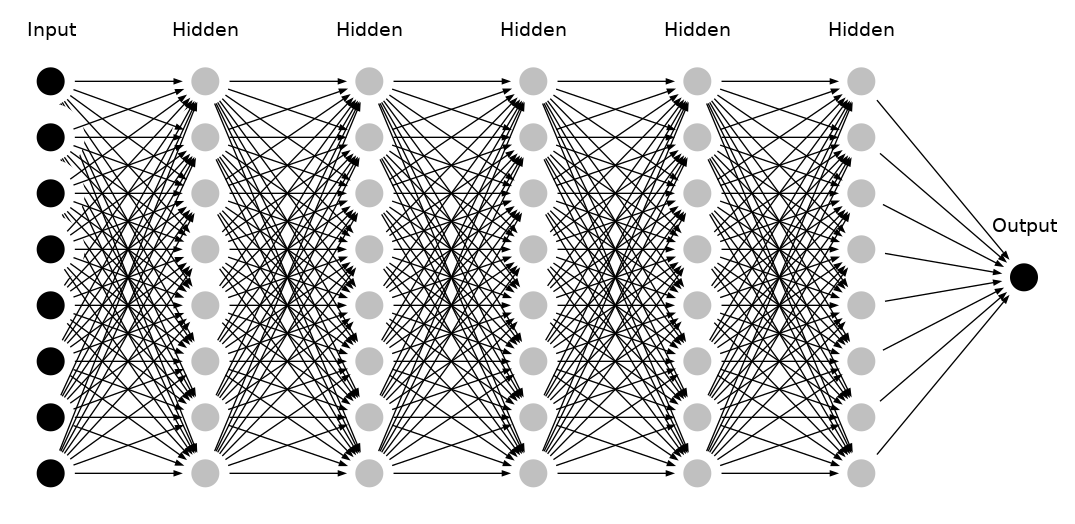

In [20]:
plotYourNeuralNet(modelVide)

ATTENTION: Pour des grandes tailles de reseau, cette visualisation n est pas adaptée et prendra beaucoup de temps a etre calcule! 
Le but vise etait ici davantage illustratif.

## **Defi!**
Créez vous un reseau de neurones en forme de noeud papillon.

In [21]:
#votre newKerasModel à créer ici



In [22]:
#afficher votre réseau



Bravo ! Vous venez de créer un réseau de neurone d'une classe très particulière: c'est un autoencoder !
Pour les curieux, vous pouvez retrouver le bestiaire des réseau de neurones ici: https://rte-france.knowledgeplaza.net/tile/view/47639/

## IV) Un premier modèle de réseau de neurones: variables calendaires + lag conso

## Choix des variables explicatives

pour ce TP, nous avons un jeu d'entrée X contenant beaucoup de variables. Afin de commencer par un modèle simple, nous allons élaguer ce X pour réduire le nombre de features en entrée. Dans ce TP, nous allons donc lister les colonnes à retirer des datasets X initialisés ci-dessus.

Pour un cas d'étude réel, une approche pragmatique serait de commencer par se créer un premier X simple, de voir les performances du modèle, puis ensuite d'incorporer de plus en plus de features dans le X pour évaluer la progression des performances de nos modèles.
Toutefois en deep learning de premiers essais sont souvent réalisés en utilisant en entrée toute l'information disponible du fait de leur capacité à "digérer" la donnée, en se nourrissant d'informations redondantes.
D'un point de vue pédagogique, nous allons commencer avec la première approche.

Pour le premier réseau de neurones que nous allons entrainer, nous allons simplement garder les variables calendaires de Xinput.

In [23]:
# Initialement
XinputTrain.head()

,weekday,lag1D,lag1W,002Th_real,005Th_real,015Th_real,027Th_real,070Th_real,110Th_real,120Th_real,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,JoursFeries_24h_avant
0,1,1.295,64948.0,-1.395,-0.999,-1.405,-0.623,-0.615,-1.086,-0.822,...,0,0,0,0,0,0,0,0,0,0.0
1,1,0.926,60196.0,-1.395,-1.065,-1.464,-0.623,-0.628,-1.127,-0.920,...,0,0,0,0,0,0,0,0,0,0.0
2,1,0.840,59062.0,-1.395,-1.130,-1.553,-0.691,-0.679,-0.819,-1.017,...,0,0,0,0,0,0,0,0,0,0.0
3,1,0.660,56809.0,-1.201,-1.328,-1.391,-0.777,-0.884,-1.086,-1.134,...,0,0,0,0,0,0,0,0,0,0.0
4,1,0.460,54476.0,-1.254,-1.574,-1.332,-0.640,-0.986,-0.984,-1.193,...,0,0,0,0,0,0,0,0,0,0.0


On sélectionne les variables que l'on souhaite conserver en précisant simplement à quelle catégorie elles appartiennent.


In [24]:
#on précise le type de variable que l'on veut conserver par une abbréviation: 
# par exemple pour sélectionner les variables associées à tous les mois, on utilise l'abbréviation month, qui sélectionenra month_1, month_2 etc...
colsType= ['lag1D','month','hour','dayOfWeek']
#any(ext in colsType for ext in extensionsToCheck)
colsToKeep=[s for s in Xinput_scaled.columns.get_values() if any(cs in s for cs in colsType)]

if('ds' in colsToKeep):#cette variable a été décomposée en mois, heure, jour et n'est plus une variable d'intérêt
    colsToKeep.remove('ds')


On restreint nos jeux d'entrainement et de tests à ces variables

In [25]:
X = XinputTrain[colsToKeep]
XTest1 = XinputTest1[colsToKeep]
XTest2 = XinputTest2[colsToKeep]

In [26]:
# Après élagage des variables
print(X.columns)
print(X.shape)
print(XTest1.shape)
print(XTest2.shape)

Index(['lag1D', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'dayOfWeek_0', 'dayOfWeek_1', 'dayOfWeek_2', 'dayOfWeek_3',
       'dayOfWeek_4', 'dayOfWeek_5', 'dayOfWeek_6', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')
(37219, 44)
(1008, 44)
(480, 44)


## Création du réseau de neurones et hyper-paramétrage
Un réseau de neurones profond est constuitué d'un certains nombre de couches, chacune portant un certain nombre de neurones. Ce sont 2 hyperparamètres que vous pouvez faire varier et qui vous permettront d'obtenir un apprentissage plus ou moins précis, en utilisant plus ou moins de puissance de calcul.

Le "learning rate" de l'optimiseur est également un hyperparamètre qui influencera la convergence et la vitesse de convergence de l'apprentissage, où l'on cherche à optimiser notre modèle pour minimiser l'erreur de prédiction. 

In [27]:
nInputs = X.shape[1]#nombre d'entrées du modèle
nOutput=1
hiddenLayers=[nInputs,nInputs,nInputs,nInputs,nInputs]

first_model = newKerasModel(nInputs,nOutput, hiddenLayers)

In [28]:
first_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [29]:
# On crée ici une instance de l'utilitaire tensorboard qui va nous permettre de visualiser les courbes d'apprnetissage de nos différents modèles.
#cf explication après la section Entrainement
from keras.callbacks import TensorBoard
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format("first_model_" +str(time())))

## Entrainement

La cellule suivante peut prendre un peu de temps à s'exécuter. On reconnait là la méthode fit commune à chaque modèle de machine learning pour entraîner son modèle.

In [30]:
# Fit the model

#en terme de paramètres:
#epoch: on précise le nombre d'epochs (le nombre de fois que l'on voit le jeu d'apprentissage en entier)
#batch size: le nombre d'exemples sur lequel on fait un "pas" d'apprentissage parmi tout le jeu
#validation_split: la proportion d'exemples que l'on conserve pour notre jeu de validation
#callbacks: pour appeler des utilitaires/fonctions externes pour récupérer des résultats
first_model.fit(X, YconsoTrain['y'], epochs=100, batch_size=100, validation_split=0.1, callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 33497 samples, validate on 3722 samples
Epoch 1/100
33497/33497 [==============================] - 0s 14us/step - loss: 1096591211.0474 - mean_absolute_percentage_error: 40.9141 - val_loss: 10157301.1052 - val_mean_absolute_percentage_error: 3.9426
Epoch 2/100
33497/33497 [==============================] - 0s 11us/step - loss: 8781622.8862 - mean_absolute_percentage_error: 4.0061 - val_loss: 10013053.7226 - val_mean_absolute_percentage_error: 3.9857
Epoch 3/100
33497/33497 [==============================] - 0s 11us/step - loss: 8575206.3608 - mean_absolute_percentage_error: 3.9859 - val_loss: 10241185.5672 - val_mean_absolute_percentage_error: 4.0805
Epoch 4/100
33497/33497 [==============================] - 0s 12us/step - loss: 8476977.5071 - mean_absolute_percentage_error: 3.9747 - val_loss: 10374606.1681 - val_mean_absolute_percentage_error: 4.1035
Epoch 5/100
33497/33497 [==============================] - 0s 11us/step - loss:

## Question
D'après les informations de logs exposées ici, quelle semble être la perfomance atteinte par votre réseau de neurones ? 


In [31]:
#Votre réponse ici


# Tensorboard
c'est un utilitaire de tensorflow qui permet de visualiser en temps réel les courbes d'apprentissage des réseau de neurones et est donc utile pour arrêter l'apprentissage si les progrès sont faibles.

En particulier, vous pouvez vous intéresser à la courbe de l'erreur (loss) d'entrainement et de validation pour visualiser la progression de l'apprentissage et une tendance au surapprentissage en fin d'apprentissage.

<img src="pictures/CourbesTensorboard.png" width=1000 height=60>

**Pour ouvrir une fenêtre tensorboard, revenez sur la page d'accueil de Jupyter, placez vous dans le dossier logs dans lequel se trouve les logs de vos entrainement, puis cliquez sur New (en haut à droite) et enfin sur Tensorboard**
Une fenêtre pop-up doit s'ouvrir. Si elle est bloquée, autorisez son ouverture.

## **Question**
Vous devriez visualiser les courbes de 2 modèles: celui que vous venez d'entrainer et un modèle qui avait été entrainé de la même manière mais avec des donénes non normalisée. Que constatez-vous ? Comment l'expliquez-vous ?


In [32]:
#Votre réponse ici


## Evaluation de la qualité du modèle

In [33]:
predictionsTrain = first_model.predict(X).reshape(-1)
predictionsTest1 = first_model.predict(XTest1).reshape(-1)
predictionsTest2 = first_model.predict(XTest2).reshape(-1)
print(predictionsTrain)

[70522.336 66005.    64732.96  ... 46868.36  48218.992 52088.805]


l'erreur relative moyenne de test est de:3.3%
l'erreur relative max de test est de:34.7%
le rmse de test est de:2447.0

l'erreur relative moyenne de train est de:2.4%
l'erreur relative max de train est de:35.0%
le rmse de test est de:2030.0


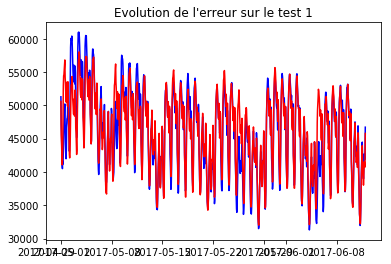

In [34]:
evaluation(YconsoTrain, YconsoTest1, predictionsTrain, predictionsTest1)
plt.plot(YconsoTest1['ds'], YconsoTest1['y'], 'b')
plt.plot(YconsoTest1['ds'], predictionsTest1, 'r')

plt.title("Evolution de l'erreur sur le test 1")
plt.show()

l'erreur relative moyenne de test est de:2.6%
l'erreur relative max de test est de:15.8%
le rmse de test est de:2014.0

l'erreur relative moyenne de train est de:2.4%
l'erreur relative max de train est de:35.0%
le rmse de test est de:2030.0


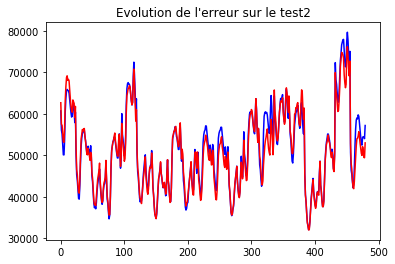

In [35]:
evaluation(YconsoTrain, YconsoTest2, predictionsTrain, predictionsTest2)

plt.plot(YconsoTest2['y'], 'b')
plt.plot(predictionsTest2, 'r')

plt.title("Evolution de l'erreur sur le test2")
plt.show()

L'erreur est ici comparable à celle des autres modèles en machine Learning (random forest, xgboost). Cela peut nous conforter dans le fait que notre réseau de neurones s'est créé de bonnes représentations pour ces variables calendaires. 

La différence en performance peut devenir plus flagrante lorsque l'on intègre des variables à une maille très granulaire (les pixels d'une images, la température dans toutes les villes de France) avec une forte interdépendance.

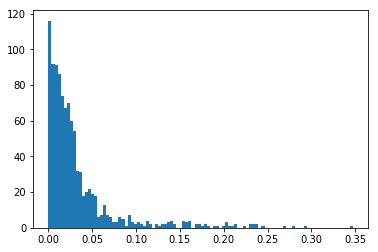

In [36]:
ErreursTest1, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YconsoTest1, predictionsTest1)
num_bins=100
plt.hist(ErreursTest1, num_bins)
plt.show()

Pour inspecter dynamiquement des visualisations, la librairie plotly se révèle très utile.
Ci-dessous vous pouvez identifier les jours et heures qui présentent les erreurs les plus importantes pour ensuite imaginer ce qui a pu pêcher.

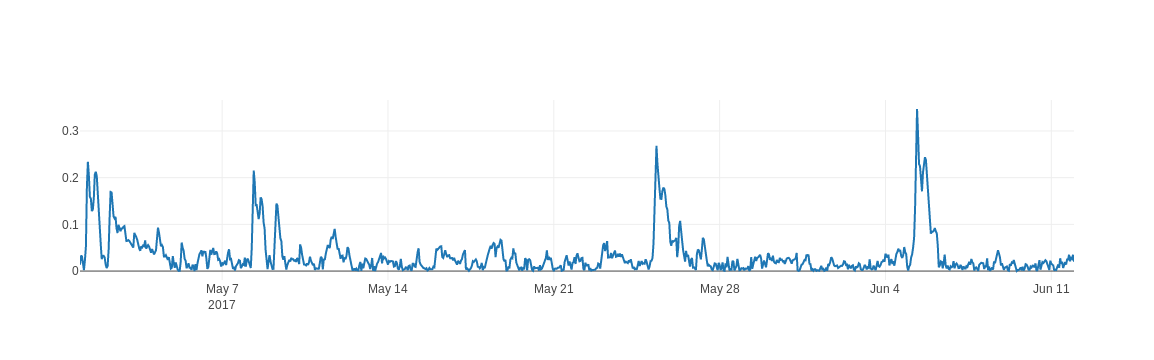

In [37]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, iplot_mpl
init_notebook_mode(connected=True)
iplot([{"x": YconsoTest1['ds'], "y": ErreursTest1}])

## **Question**
Quelles sont les heures ou les journées avec les erreurs les plus importantes. Avez-vous une idée à quoi pourrait correspondre ces heures ou ces jours ?


In [38]:
#Votre réponse ici


# A vous de jouer, faites fonctionner vos neurones :

Il peut y avoir différents objectifs de performance selon le besoin. En général on cherche un compromis entre la précision du modèle et la puissance de calcul nécessaire pour entraîner et faire tourner ce modèle.

Nous décernerons 2 récompenses!

- Défi 1: le modèle le plus précis.
- Défi 2: le modèle le plus frugal moyennant une perte de précision.
Les critères sont encore à affiner ensemble!

<img src="pictures/we-need-you.png" width=500 height=60>



# **Challenge**: entrainez et testez votre nouveau modèle avec de nouvelles variables et paramètres choisies

N'hésitez pas à vous inspirer par le code ci-dessus ;-)
venez partager vos investigations sur cette google sheet : https://docs.google.com/spreadsheets/d/1oIx8jjzIh7Ugp3ZJMCOEwns6KCJxo4ua_jW5hIvjjFI/edit?usp=sharing

# Votre modèle 

## Rappel des variables explicatives à disposition

In [39]:
# Initialement
XinputTrain.columns.get_values()

array(['weekday', 'lag1D', 'lag1W', '002Th_real', '005Th_real',
       '015Th_real', '027Th_real', '070Th_real', '110Th_real',
       '120Th_real', '130Th_real', '145Th_real', '149Th_real',
       '156Th_real', '168Th_real', '180Th_real', '190Th_real',
       '222Th_real', '240Th_real', '255Th_real', '260Th_real',
       '280Th_real', '299Th_real', '434Th_real', '460Th_real',
       '481Th_real', '497Th_real', '510Th_real', '579Th_real',
       '588Th_real', '621Th_real', '630Th_real', '643Th_real',
       '645Th_real', '650Th_real', '675Th_real', '690Th_real',
       '747Th_real', 'FranceTh_real', '002Th_prev', '005Th_prev',
       '015Th_prev', '027Th_prev', '070Th_prev', '110Th_prev',
       '120Th_prev', '130Th_prev', '145Th_prev', '149Th_prev',
       '156Th_prev', '168Th_prev', '180Th_prev', '190Th_prev',
       '222Th_prev', '240Th_prev', '255Th_prev', '260Th_prev',
       '280Th_prev', '299Th_prev', '434Th_prev', '460Th_prev',
       '481Th_prev', '497Th_prev', '510Th_prev', '5

## Choix des variables explicatives

On sélectionne les variables que l'on souhaite conserver en précisant simplement à quelle catégorie elles appartiennent.

In [ ]:
#########
#TO DO
#Préciser le type de variable que l'on veut conserver par une abbréviation
colsType=  [] #['lag1D','month','hour','dayOfWeek']

#Fin TO DO
#########

colsToKeep=[s for s in Xinput.columns.get_values() if any(cs in s for cs in colsType)]

if('ds' in colsToKeep):#cette variable a été décomposée en mois, heure, jour et n'est plus une variable d'intérêt
    colsToKeep.remove('ds')

In [ ]:
X = XinputTrain[colsToKeep]
XTest1 = XinputTest1[colsToKeep]
XTest2 = XinputTest2[colsToKeep]

In [ ]:
# Après élagage
print(X.columns)
print(X.shape)
print(XTest1.shape)
print(XTest2.shape)

## Création du réseau de neurones, hyper-paramétrage

Vous pouvez jouer sur l'architecture de votre reseau de neurones ici en précisant le nombre de couches et la taille des couches dans le vecteur hiddenLayers

In [ ]:
nInputs = X.shape[1]#nombre d'entrées du modèle
nOutput=1

##votre choix
hiddenLayers=[nInputs,nInputs,nInputs,nInputs,nInputs]
####

votre_model_scaled_1 = newKerasModel(nInputs,nOutput, hiddenLayers)

In [ ]:
votre_model_scaled_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

# Tensorboard
c'est un utilitaire de tensorflow qui permet de visualiser en temps réel les courbes d'apprentissage des réseau de neurones et est donc utile pour arrêter l'apprentissage si les progrès sont faibles.

In [ ]:
# Ajouter la ligne ci-dessous lève le problème
from keras.callbacks import TensorBoard
from time import time

#preciser le nom de votre modele avec les variables utilisees pour le visualiser dans tensorboard
nomModele=None#'votre_model_scaled_nomVariables'
tensorboard = TensorBoard(log_dir="logs/{}".format(nomModele +str(time())))

## Entrainement

La cellule suivante peut prendre un peu de temps à s'exécuter.

In [ ]:
# Fit the model
votre_model_scaled_1.fit(X, YconsoTrain['y'], epochs=150, batch_size=100, validation_split=0.1, callbacks=[tensorboard])

## Evaluation de la qualité du modèle

In [ ]:
predictionsTrain = votre_model_scaled_1.predict(X).reshape(-1)
predictionsTest1 = votre_model_scaled_1.predict(XTest1).reshape(-1)
predictionsTest2 = votre_model_scaled_1.predict(XTest2).reshape(-1)
print(predictionsTrain)

In [ ]:
evaluation(YconsoTrain, YconsoTest1, predictionsTrain, predictionsTest1)
plt.plot(YconsoTest1['ds'], YconsoTest1['y'], 'b')
plt.plot(YconsoTest1['ds'], predictionsTest1, 'r')

plt.title("Evolution de l'erreur sur le test 1")
plt.show()

In [ ]:
evaluation(YconsoTrain, YconsoTest2, predictionsTrain, predictionsTest2)

plt.plot(YconsoTest2['y'], 'b')
plt.plot(predictionsTest2, 'r')

plt.title("Evolution de l'erreur sur le test2")
plt.show()

L'erreur est ici comparable à celle de Prophet (5,8%) qui modèle nativement la notion de temps. Cela peut nous conforter dans le fait que notre réseau de neurones s'est créé de bonnes représentations pour ces variables calendaires

In [ ]:
ErreursTest1, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YconsoTest1, predictionsTest1)
num_bins=100
plt.hist(ErreursTest1, num_bins)
plt.show()

In [ ]:
init_notebook_mode(connected=True)
iplot([{"x": YconsoTest1['ds'], "y": ErreursTest1}])

# Pour aller encore plus loin

Le modèle ci-dessus peut être rendu encore plus performant par exemple en considérant des features comme "jour d'avant vacances", "jour d'après vacances"... 

Passer du temps à tuner les hyper-paramètres serait certainement bénéfique aussi.

De manière assez surprenante, élargir le réseau de neurones pour prédire les consommations régionales peut également améliorer la qualité de la prédiction de l'échelle nationale. C'est l'idée du multi-tasking.

On pourra également considérer en sortie du modèle non pas la prédiction pour juste 24 heures plus tard, mais plutôt pour une plage horaire  
[1 heure plus tard, ..., 24 heures plus tard]. Ceci permet de capter des dynamiques.


Des pistes:
insérer le lag Jours_Feries_J-1
voir si un intérêt à passer toutes les stations ou seulement la température France avec expertise sur importance des stations (en fait ça suffit avec les stations fournies!)


## Exemple d apprentissage avec differentes variables


### **Question**
Saurez-vous retrouver les variables utilisé pour ces differents apprentissages ?
A piocher parmi variables calendaires,lag de conso, tempreature, jours feries

<img src="pictures/ResultsApprentissages.png" width=500 height=50>